# Baseline implementation using GPT-3.5 turbo.

## Relevant imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import openai
import time
import csv
import nltk
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [2]:
# OpenAI API credentials
openai.api_key = 'Your_Key'

## Data Preprocessing

In [3]:
# Load the original dataset
data = pd.read_csv("data.csv")

## Subset 1
Creating a subset of 150 unique values while keeping the distribution same as the original dataset.

In [4]:
# Subset 1: Same Distribution
subset_same_distribution = pd.DataFrame()
categories_same_distribution = ['neutral', 'positive', 'negative']
percentages_same_distribution = [0.54, 0.32, 0.15]
num_samples_same_distribution = 150

for category, percentage in zip(categories_same_distribution, percentages_same_distribution):
    num_samples = int(percentage * num_samples_same_distribution)
    samples = data[data['Sentiment'] == category].sample(num_samples)
    subset_same_distribution = subset_same_distribution.append(samples)

##  Subset 2
Creating a subset of 150 unique values while keeping the distribution equal (50 values each).

In [5]:
# Subset 2: Equal Distribution
subset_equal_distribution = pd.DataFrame()
num_samples_equal_distribution = 50

for category in categories_same_distribution:
    samples = data[data['Sentiment'] == category].sample(num_samples_equal_distribution)
    subset_equal_distribution = subset_equal_distribution.append(samples)

## Checking the distributions

In [6]:
subset_same_distribution['Sentiment'].value_counts(normalize=True)

neutral     0.536424
positive    0.317881
negative    0.145695
Name: Sentiment, dtype: float64

In [7]:
subset_equal_distribution['Sentiment'].value_counts(normalize=True)

neutral     0.333333
positive    0.333333
negative    0.333333
Name: Sentiment, dtype: float64

## Tokenizing the Prompt

In [8]:
# Download the required NLTK tokenizer data
nltk.download('punkt')

# Define the prompt
prompt = "Predict the sentiment of the following financial news text in only one word as: positive, neutral, or negative."
predicted_labels = []

# Tokenize the prompt
tokenized_prompt = nltk.word_tokenize(prompt)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sarthak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Prompt execution class
The OpenAI API allows a maximum of **3** requests per minute and is often overloaded with requests hence , a time delay of 60 seconds was introduced between each batch of two requests.

In [9]:
# Define the maximum number of requests and the delay between each batch
max_requests = 75
batch_size = 2
delay_seconds = 60

# Function to execute prompt for a batch of texts
def execute_prompt(batch_texts):
    predicted_labels = []
    for text in batch_texts:
        # Tokenize the text
        tokenized_text = nltk.word_tokenize(text)

        # Combine the tokenized prompt and tokenized text
        combined_text = " ".join(tokenized_prompt + tokenized_text)

        completion = openai.ChatCompletion.create(model="gpt-3.5-turbo", messages=[{"role": "system", "content": combined_text}])
        predicted_label = completion.choices[0].message.content.lower()
        predicted_labels.append(predicted_label)
    return predicted_labels


## Prompt execution for subset 1

In [10]:
# Execute prompt for Subset 1: Same Distribution
texts_same_distribution = subset_same_distribution['Sentence'].tolist()
true_labels_same_distribution = subset_same_distribution['Sentiment'].tolist()
predicted_labels_same_distribution = []

for i in range(0, max_requests, batch_size):
    batch_texts = texts_same_distribution[i:i+batch_size]  # Get the batch of texts
    predicted_labels = execute_prompt(batch_texts)
    predicted_labels_same_distribution.extend(predicted_labels)
    if i + batch_size < len(texts_same_distribution):
        time.sleep(delay_seconds)  # Delay between each batch

# Save predicted labels for Subset 1 to CSV file
output_file_same_distribution = "predicted_labels_same_distribution.csv"
with open(output_file_same_distribution, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Text", "True Label", "Predicted Label"])
    for text, true_label, predicted_label in zip(texts_same_distribution, true_labels_same_distribution, predicted_labels_same_distribution):
        writer.writerow([text, true_label, predicted_label])
print("Predicted labels for Subset 1 saved to:", output_file_same_distribution)


Predicted labels for Subset 1 saved to: predicted_labels_same_distribution.csv


## Prompt execution for subset 2

In [13]:
# Execute prompt for Subset 2: Equal Distribution
texts_equal_distribution = subset_equal_distribution['Sentence'].tolist()
true_labels_equal_distribution = subset_equal_distribution['Sentiment'].tolist()
predicted_labels_equal_distribution = []

for i in range(0, max_requests, batch_size):
    batch_texts = texts_equal_distribution[i:i+batch_size]  # Get the batch of texts
    predicted_labels = execute_prompt(batch_texts)
    predicted_labels_equal_distribution.extend(predicted_labels)
    if i + batch_size < len(texts_equal_distribution):
        time.sleep(delay_seconds)  # Delay between each batch

# Save predicted labels for Subset 2 to CSV file
output_file_equal_distribution = "predicted_labels_equal_distribution.csv"
with open(output_file_equal_distribution, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Text", "True Label", "Predicted Label"])
    for text, true_label, predicted_label in zip(texts_equal_distribution, true_labels_equal_distribution, predicted_labels_equal_distribution):
        writer.writerow([text, true_label, predicted_label])
print("Predicted labels for Subset 2 saved to:", output_file_equal_distribution)

Predicted labels for Subset 2 saved to: predicted_labels_equal_distribution.csv


## Evaluation Metrics

Subset 1: Same Distribution
Accuracy: 0.57
Precision: 1.00
Recall: 0.57
F1-score (Weighted): 0.72



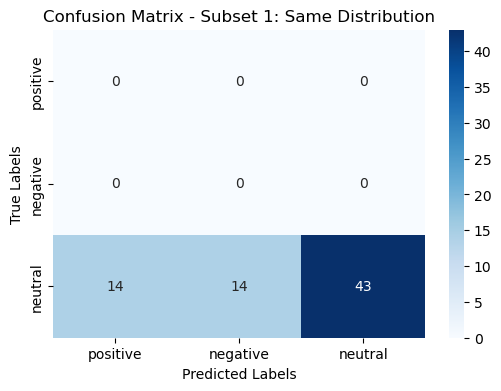


Subset 2: Equal Distribution
Accuracy: 0.61
Precision: 0.82
Recall: 0.61
F1-score (Weighted): 0.68



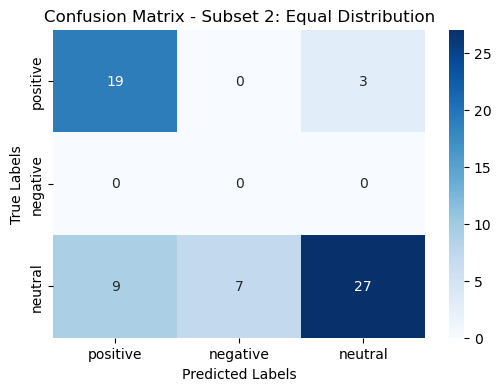

In [16]:
# Ensure the number of samples matches for true and predicted labels
true_labels_same_distribution = true_labels_same_distribution[:len(predicted_labels_same_distribution)]

# Calculate accuracy metrics for Subset 1: Same Distribution
accuracy_same_distribution = accuracy_score(true_labels_same_distribution, predicted_labels_same_distribution)
precision_same_distribution = precision_score(true_labels_same_distribution, predicted_labels_same_distribution, average='weighted')
recall_same_distribution = recall_score(true_labels_same_distribution, predicted_labels_same_distribution, average='weighted')
f1_same_distribution = f1_score(true_labels_same_distribution, predicted_labels_same_distribution, average='weighted')

# Print accuracy metrics for Subset 1: Same Distribution
print("Subset 1: Same Distribution")
print("Accuracy: {:.2f}".format(accuracy_same_distribution))
print("Precision: {:.2f}".format(precision_same_distribution))
print("Recall: {:.2f}".format(recall_same_distribution))
print("F1-score (Weighted): {:.2f}".format(f1_same_distribution))
print()


# Create confusion matrix for Subset 1: Same Distribution
confusion_matrix_same_distribution = confusion_matrix(true_labels_same_distribution, predicted_labels_same_distribution, labels=['positive', 'negative', 'neutral'])

# Plot confusion matrix for Subset 1: Same Distribution
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix_same_distribution, annot=True, fmt="d", cmap="Blues",
            xticklabels=['positive', 'negative', 'neutral'],
            yticklabels=['positive', 'negative', 'neutral'])
plt.title("Confusion Matrix - Subset 1: Same Distribution")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
print()

# Ensure the number of samples matches for true and predicted labels
true_labels_equal_distribution = true_labels_equal_distribution[:len(predicted_labels_equal_distribution)]

# Calculate accuracy metrics for Subset 2: Equal Distribution
accuracy_equal_distribution = accuracy_score(true_labels_equal_distribution, predicted_labels_equal_distribution)
precision_equal_distribution = precision_score(true_labels_equal_distribution, predicted_labels_equal_distribution, average='weighted')
recall_equal_distribution = recall_score(true_labels_equal_distribution, predicted_labels_equal_distribution, average='weighted')
f1_equal_distribution = f1_score(true_labels_equal_distribution, predicted_labels_equal_distribution, average='weighted')

# Print accuracy metrics for Subset 2: Equal Distribution
print("Subset 2: Equal Distribution")
print("Accuracy: {:.2f}".format(accuracy_equal_distribution))
print("Precision: {:.2f}".format(precision_equal_distribution))
print("Recall: {:.2f}".format(recall_equal_distribution))
print("F1-score (Weighted): {:.2f}".format(f1_equal_distribution))
print()

# Create confusion matrix for Subset 2: Equal Distribution
confusion_matrix_equal_distribution = confusion_matrix(true_labels_equal_distribution, predicted_labels_equal_distribution, labels=['positive', 'negative', 'neutral'])

# Plot confusion matrix for Subset 2: Equal Distribution
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix_equal_distribution, annot=True, fmt="d", cmap="Blues",
            xticklabels=['positive', 'negative', 'neutral'],
            yticklabels=['positive', 'negative', 'neutral'])
plt.title("Confusion Matrix - Subset 2: Equal Distribution")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Class based evaluation metrics for subset 1

In [20]:
class_names = ['negative', 'neutral', 'positive']


# Define lists to store the metric values for each class
accuracy_list = []
precision_weighted_list = []
precision_macro_list = []
recall_weighted_list = []
recall_macro_list = []
f1_weighted_list = []
f1_macro_list = []

for class_name in class_names:
    # Filter labels for the current class
    class_indices = [i for i in range(len(true_labels_same_distribution)) if true_labels_same_distribution[i] == class_name]
    true_labels_class = [true_labels_same_distribution[i] for i in class_indices]
    predicted_labels_class = [predicted_labels_same_distribution[i] for i in class_indices]

    # Calculate metrics for the current class
    accuracy_class = accuracy_score(true_labels_class, predicted_labels_class)
    precision_weighted_class = precision_score(true_labels_class, predicted_labels_class, average='weighted')
    precision_macro_class = precision_score(true_labels_class, predicted_labels_class, average='macro')
    recall_weighted_class = recall_score(true_labels_class, predicted_labels_class, average='weighted')
    recall_macro_class = recall_score(true_labels_class, predicted_labels_class, average='macro')
    f1_weighted_class = f1_score(true_labels_class, predicted_labels_class, average='weighted')
    f1_macro_class = f1_score(true_labels_class, predicted_labels_class, average='macro')
    
    # Append the metric values to the corresponding lists
    accuracy_list.append(accuracy_class)
    precision_weighted_list.append(precision_weighted_class)
    precision_macro_list.append(precision_macro_class)
    recall_weighted_list.append(recall_weighted_class)
    recall_macro_list.append(recall_macro_class)
    f1_weighted_list.append(f1_weighted_class)
    f1_macro_list.append(f1_macro_class)

    # Print metrics for the current class
    print(f"Metrics for {class_name.capitalize()} Class:")
    print("Accuracy:", format(accuracy_class, ".2f"))
    print("Precision (Weighted):", format(precision_weighted_class, ".2f"))
    print("Precision (Macro):", format(precision_macro_class, ".2f"))
    print("Recall (Weighted):", format(recall_weighted_class, ".2f"))
    print("Recall (Macro):", format(recall_macro_class, ".2f"))
    print("F1-score (Weighted):", format(f1_weighted_class, ".2f"))
    print("F1-score (Macro):", format(f1_macro_class, ".2f"))
    print()

Metrics for Negative Class:
Accuracy: nan
Precision (Weighted): 0.00
Precision (Macro): nan
Recall (Weighted): 0.00
Recall (Macro): nan
F1-score (Weighted): 0.00
F1-score (Macro): nan

Metrics for Neutral Class:
Accuracy: 0.57
Precision (Weighted): 1.00
Precision (Macro): 0.17
Recall (Weighted): 0.57
Recall (Macro): 0.09
F1-score (Weighted): 0.72
F1-score (Macro): 0.12

Metrics for Positive Class:
Accuracy: nan
Precision (Weighted): 0.00
Precision (Macro): nan
Recall (Weighted): 0.00
Recall (Macro): nan
F1-score (Weighted): 0.00
F1-score (Macro): nan



## Class based evaluation metrics for subset 2

In [21]:
class_names = ['negative', 'neutral', 'positive']


# Define lists to store the metric values for each class
accuracy_list = []
precision_weighted_list = []
precision_macro_list = []
recall_weighted_list = []
recall_macro_list = []
f1_weighted_list = []
f1_macro_list = []

for class_name in class_names:
    # Filter labels for the current class
    class_indices = [i for i in range(len(true_labels_equal_distribution)) if true_labels_equal_distribution[i] == class_name]
    true_labels_class = [true_labels_equal_distribution[i] for i in class_indices]
    predicted_labels_class = [predicted_labels_equal_distribution[i] for i in class_indices]

    # Calculate metrics for the current class
    accuracy_class = accuracy_score(true_labels_class, predicted_labels_class)
    precision_weighted_class = precision_score(true_labels_class, predicted_labels_class, average='weighted')
    precision_macro_class = precision_score(true_labels_class, predicted_labels_class, average='macro')
    recall_weighted_class = recall_score(true_labels_class, predicted_labels_class, average='weighted')
    recall_macro_class = recall_score(true_labels_class, predicted_labels_class, average='macro')
    f1_weighted_class = f1_score(true_labels_class, predicted_labels_class, average='weighted')
    f1_macro_class = f1_score(true_labels_class, predicted_labels_class, average='macro')
    
    # Append the metric values to the corresponding lists
    accuracy_list.append(accuracy_class)
    precision_weighted_list.append(precision_weighted_class)
    precision_macro_list.append(precision_macro_class)
    recall_weighted_list.append(recall_weighted_class)
    recall_macro_list.append(recall_macro_class)
    f1_weighted_list.append(f1_weighted_class)
    f1_macro_list.append(f1_macro_class)

    # Print metrics for the current class
    print(f"Metrics for {class_name.capitalize()} Class:")
    print("Accuracy:", format(accuracy_class, ".2f"))
    print("Precision (Weighted):", format(precision_weighted_class, ".2f"))
    print("Precision (Macro):", format(precision_macro_class, ".2f"))
    print("Recall (Weighted):", format(recall_weighted_class, ".2f"))
    print("Recall (Macro):", format(recall_macro_class, ".2f"))
    print("F1-score (Weighted):", format(f1_weighted_class, ".2f"))
    print("F1-score (Macro):", format(f1_macro_class, ".2f"))
    print()

Metrics for Negative Class:
Accuracy: nan
Precision (Weighted): 0.00
Precision (Macro): nan
Recall (Weighted): 0.00
Recall (Macro): nan
F1-score (Weighted): 0.00
F1-score (Macro): nan

Metrics for Neutral Class:
Accuracy: 0.54
Precision (Weighted): 1.00
Precision (Macro): 0.17
Recall (Weighted): 0.54
Recall (Macro): 0.09
F1-score (Weighted): 0.70
F1-score (Macro): 0.12

Metrics for Positive Class:
Accuracy: 0.73
Precision (Weighted): 1.00
Precision (Macro): 0.33
Recall (Weighted): 0.73
Recall (Macro): 0.24
F1-score (Weighted): 0.84
F1-score (Macro): 0.28

